# Outline

This notebook includes the following:
0. [Section 0: imports and setup.](#imports) Note you will need ``pyblip`` installed to run this notebook (just run ``python3.9 -m pip install -U pyblip``).

1. [Section 1: Reproducible examples](#examples), including:
    1. [Pictures/examples of the covariance matrices we use in our simulation](#cov_ex)
    
    2. [A simple example showing the importance of resolution-adaptivity](#ftest)
    
    3. [A more realistic variable selection example](#varselect)
    
    4. [Two examples for changepoint detection](#changepoint_ex)
    
    5. [Other miscallaneous examples which are used in our presentations (but which are not present in the paper).](#misc_ex)
    
    
2. [Section 2: Plots for simulations](#sims). This part of the notebook is just the code used to create the simulation plots for the paper. *Note*: This part of the notebook will not run unless you run simulations in advance using the blip_sims/sims/ scripts. Once you run the simulations, you need to tell the jupyter notebook where the output files are located and then you can generate plots that way.
    1. [Plots showing BLiP is nearly optimal](#nearopt)
    2. [The main simulation setting: variable selection in high-dimensional Gaussian linear models](#mainsim)
    3. [Power and computation in high-dimensions](#varyp)
    4. [Probit regression](#probit)
    5. [Changepoint detection simulations](#changepoint_sim)
    6. [Robustness to MCMC convergence issues](#mcmc)
    7. [Analysis of where SuSiE + BLiP gains its power](#susie)
    8. [BLiP's sensitivity to the weight function](#jaccard)

<a id='imports'></a>
# 0. Imports and setup

In [36]:
import sys
import os
import glob
from tqdm import tqdm
import time

file_path = os.getcwd()
parent_dir = os.path.split(file_path)[0]
sys.path.insert(0, parent_dir + "/pyblip/")
sys.path.insert(0, parent_dir + "/blip_sims/")
import pyblip
import blip_sims
print(pyblip.__version__) # should be >= 0.4.2

0.4.2


In [37]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns
from plotnine import *

In [4]:
def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_se'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

<a id='examples'></a>
# 1. Reproducible examples

<a id='cov_ex'></a>
## 1(a) Example of covariance matrix

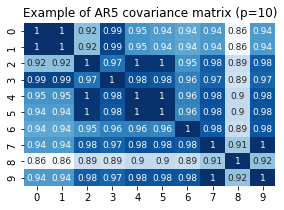

In [959]:
_, _, _, V = blip_sims.gen_data.generate_regression_data(
    p=10, k=3, covmethod='ark', return_cov=True, dgp_seed=12345678,
    max_corr=0.999, alpha0=0.125
)
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.heatmap(V, cmap='Blues', annot=True, ax=ax, annot_kws={"fontsize":9}, cbar=False)
ax.set(title="Example of AR5 covariance matrix (p=10)")
plt.savefig("final-plots/examples/ar5_cov.png", dpi=500)

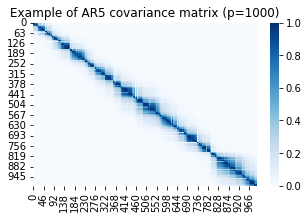

In [960]:
_, _, _, V = blip_sims.gen_data.generate_regression_data(
    p=1000, k=3, covmethod='ark', return_cov=True, dgp_seed=12345678,
    max_corr=0.999, alpha0=0.125,
)
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(V, cmap='Blues', ax=ax, annot_kws={"fontsize":9}, cbar=True)
ax.set(title=f"Example of AR5 covariance matrix (p={V.shape[0]})")
plt.savefig("final-plots/examples/ar5_cov_p1000.png", dpi=500)

In [948]:
p = V.shape[0]
print(np.quantile(np.max(V - np.eye(p), axis=0), np.array([0.1, 0.5, 0.9])))
np.mean(np.diag(V, 1))

[0.92555435 0.99270773 0.99923952]


0.8632396374822864

<a id='ftest'></a>
## 1(b) F-test example from Appendix A

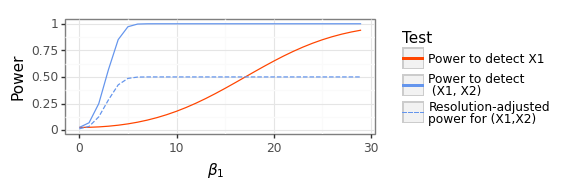

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 1.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/examples/ftest_example.png


In [1141]:
# Columns for data-matrix
columns = [
    'beta1', 
    'Power to detect X1',
    'Power to detect \n (X1, X2)',
    'Resolution-adjusted\npower for (X1,X2)']
output = []

# Parameters
n = 20
alpha = 0.05
rho = 0.99

# Thresholds with bonferonni correction
t1 = stats.f(dfn=1, dfd=n-2).ppf(1-alpha/2)
t2 = stats.f(dfn=2, dfd=n-2).ppf(1-alpha/2)

# Power of tests for various beta
betas = np.arange(30)
mu1 = (1 - rho**2) * np.power(betas, 2)
mu2 = np.power(betas, 2)
power1 = 1 - stats.ncf(nc=mu1, dfn=1, dfd=n-2).cdf(t1)
power2 = (1 - stats.ncf(nc=mu2, dfn=2, dfd=n-2).cdf(t2))
res_adj_power2 = power2 / 2

# Put into dataframe and plot
df = pd.DataFrame(columns=columns)
df['beta1'] = betas
df[columns[1]] = power1
df[columns[2]] = power2
df[columns[3]] = res_adj_power2
df = pd.melt(df, id_vars=['beta1'], value_name='Power', var_name='Test')
df['Test'] = pd.Categorical(
    df['Test'], 
    ordered=True, 
    categories=columns[1:4]
)
g = (
    ggplot(
        df, 
        aes(x='beta1', y='Power', color='Test')
    )
    + geom_line(aes(linetype='Test'))
    #+ geom_point()
    + theme_bw()
    + theme(figure_size=(4,1.5))
    + labs(
        x=r'$\beta_1$',
        y='Power'
    )
    + scale_linetype_manual(['solid', 'solid', 'dashed'])
    + scale_color_manual(['orangered', 'cornflowerblue', 'cornflowerblue'])
)
print(g)
g.save("final-plots/examples/ftest_example.png", dpi=500)

/tmp/ipykernel_21641/1271561367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


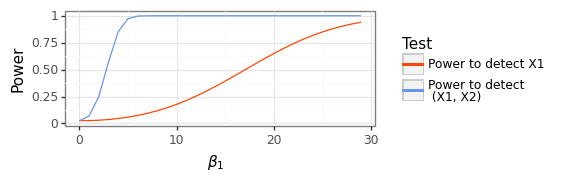

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 1.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: presentation_plots/examples/ftest_example.png


In [1142]:
# Repeat the above but without resolution-adjusted power, for presentations
subset = df.loc[~df['Test'].str.contains("Resolution")]
subset['Test'] = pd.Categorical(
    subset['Test'], 
    ordered=True, 
    categories=columns[1:3]
)
g = (
    ggplot(
        subset, 
        aes(x='beta1', y='Power', color='Test')
    )
    + geom_line(aes(linetype='Test'))
    #+ geom_point()
    + theme_bw()
    + theme(figure_size=(4,1.5))
    + labs(
        x=r'$\beta_1$',
        y="Power",
    )
    + scale_linetype_manual(['solid', 'solid', 'dashed'])
    + scale_color_manual(['orangered', 'cornflowerblue', 'cornflowerblue'])
)
print(g)
g.save("presentation_plots/examples/ftest_example.png", dpi=500)

In [47]:
def H_mat(X):
    inv = np.linalg.inv(np.dot(X.T, X))
    return np.dot(X, np.dot(inv, X.T))

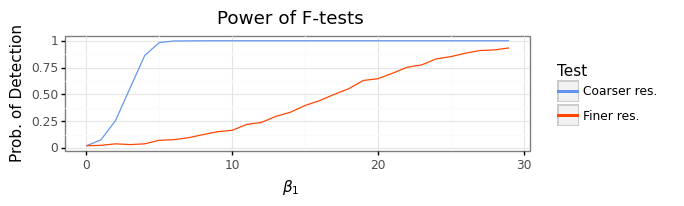

In [48]:
#### For testing, we also simulate the power curves.
#### This plot is not published since it's just
#### a sanity check :)

n = 20
cov = np.array([[1, rho], [rho, 1]])
L = np.linalg.cholesky(cov)

# Generate X s.t. XTX = cov
X = np.dot(L, np.random.randn(2, n-2)).T / np.sqrt(5*(n-2))
cov_left = cov - np.dot(X.T, X)
L_left = np.linalg.cholesky(cov_left)
X = np.concatenate([X, L_left.T], axis=0)

# Invert
XTXinv = np.linalg.inv(np.dot(X.T, X))

# For f-tests
H = H_mat(X)
H2 = H_mat(X[:, [1]])

# Generate y | X
for beta1 in betas:
    for j in range(1000):
        y = X[:, 0] * beta1 + np.random.randn(n)

        # F-test testing beta1, beta2 = 0
        denom = np.dot(y, np.dot(np.eye(n) - H, y)) / (n - 2)
        T1 = np.dot(y, np.dot(H - H2, y)) / denom
        T2 = np.dot(y, np.dot(H, y)) / 2 / denom

        # append
        output.append([beta1, T1 > t1, T2 > t2])

cols= ['beta1', 'Finer res.', 'Coarser res.']
df = pd.DataFrame(output, columns=cols)
df = pd.melt(df, id_vars=['beta1'], value_name='Power', var_name='Test')
agg = calc_mean_sem(
    df, 
    group_vals=['beta1', 'Test'], 
    meas=['Power']
)
g = (
    ggplot(
        agg, 
        aes(x='beta1', y='Power_mean', color='Test')
    )
    + geom_line()
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(
        title='Power of F-tests', 
        x=r'$\beta_1$',
        y='Prob. of Detection'
    )
    + scale_color_manual(['cornflowerblue', 'orangered'])
)
print(g)

<a id='varselect'></a>
## 1(c) Variable selection example in Appendix 

In [784]:
seed = 1234
n, p, q, tau = 250, 1000, 0.1, 4
np.random.seed(seed)
_, _, _, cov = blip_sims.gen_data.generate_regression_data(
    n=n, p=p, k=5, covmethod='ark', return_cov=True,
    alpha0=0.05,
    dgp_seed=seed,
)
np.random.seed(seed)
X = np.random.randn(n, p) @ np.linalg.cholesky(cov).T

# Sparse coefficients
beta = np.zeros(p)
sparsities = [0.005, 0.05]
changepoint = 800
# sparse signals in first part
sigs1 = np.linspace(0, changepoint - 50, int(sparsities[0] * changepoint))
sigsizes1 = tau * np.random.binomial(1, 0.5, len(sigs1)) - 1
# dense signals in last part
sigs2 = np.sort(np.random.choice(
    np.arange(changepoint, p),
    int(sparsities[1] * (p - changepoint)),
    replace=False,
))
sigsizes2 = tau/2 * (2 * np.random.binomial(1, 0.5, len(sigs2)) - 1)
# concatenate
signals = np.concatenate([sigs1, sigs2]).astype(int)
sig_sizes = np.concatenate([sigsizes1, sigsizes2])
beta[signals] = sig_sizes
y = np.random.randn(n) + np.dot(X, beta)

# for manhattan plot
XTY = np.dot(X.T, y)
Xl2 = np.diag(np.dot(X.T, X))
Zscore = np.abs(XTY) / np.sqrt(Xl2)
log10_pvals = - 1 * (stats.norm.logcdf(- Zscore) + np.log(2)) / np.log(10)

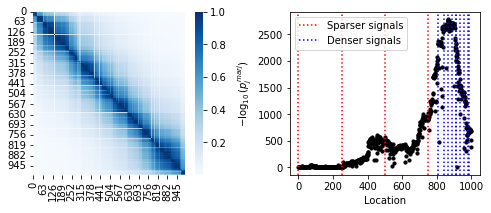

In [785]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
sns.heatmap(cov, cmap='Blues', ax=ax[0])
ax[1].scatter(np.arange(p), log10_pvals, color='black', s=10)
for j, xval in enumerate(signals):
    if j == 0:
        label = 'Sparser signals'
        color = 'red'
    elif j == len(sigs1):
        label = 'Denser signals'
        color = 'blue'
    else:
        label = None
    ax[1].axvline(xval, color=color, linestyle='dotted', label=label)
ax[1].set(xlabel='Location', ylabel=r'$-\log_{10}(p^{marj}_j)$')
ax[1].legend()
plt.subplots_adjust(wspace=0.35)
plt.savefig("final-plots/appendixsims/example_descriptive.png", dpi=500, bbox_inches='tight')
plt.show()

In [786]:
def create_gsizes_output(detections, signals, plot=False):
    try:
        detections[0].group
        return create_gsizes_output([list(x.group) for x in detections], signals, plot=plot)
    except:
        pass
    gsizes = np.zeros(len(signals))
    for j, signal in enumerate(signals):
        for x in detections:
            if signal in x:
                gsizes[j] = 1 / len(x)
                continue
    if not plot:
        return gsizes
    else:
        plt.scatter(signals, gsizes)
        plt.show()

In [787]:
def print_output(detections, beta):
    try:
        detections[0].group
        return print_output([list(x.group) for x in detections], beta)
    except:
        pass
    detections = sorted(detections, key = lambda x: min(x))
    flags = [np.any(beta[x] != 0) for x in detections]
    for flag, x in zip(flags, detections):
        print((flag, sorted(x)))
    return None
    

In [776]:
## 1. SuSiE and SuSiE + BLiP

(True, [0, 1, 2, 3])
(True, [240, 244, 245, 247, 249, 250, 251, 253, 254, 255, 256, 257, 258])
(True, [500])
(True, [719, 721, 723, 724, 725, 726, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 744, 745, 746, 747, 748, 749, 750, 751, 752, 756])
(True, [808, 809])
(False, [882])
(False, [919])
(True, [947, 949, 950, 953, 955, 957, 958])


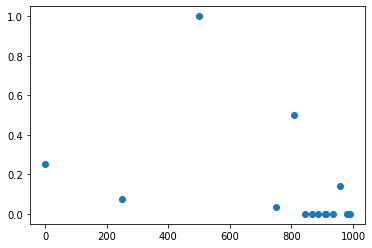

CPU times: user 34.3 s, sys: 32.4 s, total: 1min 6s
Wall time: 6.04 s


In [788]:
%%time
susie_alpha, susie_sets = blip_sims.susie.run_susie(X=X, y=y, L=len(signals), q=q)
print_output(susie_sets, beta)
create_gsizes_output(susie_sets, signals, plot=True)

BLiP problem has 1666 groups in contention, with 315 active features/locations
(True, [0, 1, 2])
(True, [240, 244, 245, 247, 249, 250, 251, 253, 254, 255, 256, 257, 258])
(True, [500])
(True, [733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752])
(True, [809])
(False, [882])
(False, [919])
(True, [947, 949, 950, 953, 955, 957, 958])


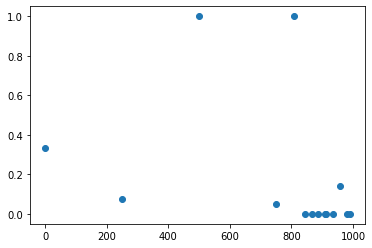

CPU times: user 235 ms, sys: 115 ms, total: 350 ms
Wall time: 168 ms


In [789]:
%%time
susie_cgs = pyblip.create_groups.susie_groups(susie_alpha, q=q)
susie_blip_detections = pyblip.blip.BLiP(
    cand_groups=susie_cgs,
    q=q,
    error='fdr',
)
print_output(susie_blip_detections, beta)
create_gsizes_output(susie_blip_detections, signals, plot=True)

In [779]:
## 2. BLiP

In [790]:
%%time 
lm = pyblip.linear.LinearSpikeSlab(X=X, y=y)
lm.sample(N=2000, bsize=5, chains=10)

CPU times: user 2min 1s, sys: 7.57 s, total: 2min 8s
Wall time: 1min 55s


In [791]:
%%time
cand_groups = pyblip.create_groups.all_cand_groups(
    samples=lm.betas,
    q=q,
)
lss_blip_detections = pyblip.blip.BLiP(
    cand_groups=cand_groups,
    q=q,
    error='fdr',
)

BLiP problem has 2993 groups in contention, with 577 active features/locations
LP had 2 non-integer solutions across 1 locations. Binarizing with deterministic=True.
CPU times: user 7.04 s, sys: 2.77 s, total: 9.81 s
Wall time: 4.5 s


In [794]:
signals

array([  0, 250, 500, 750, 809, 845, 868, 887, 909, 912, 934, 957, 979,
       989])

(True, [0, 1, 2, 3, 7])
(True, [244, 249, 250, 251, 253, 254, 255, 256, 257, 258])
(True, [500])
(True, [749, 750])
(True, [809])
(True, [834, 843, 845])
(True, [863, 864, 868])
(True, [882, 884, 886, 887])
(True, [904, 909])
(True, [912, 917])
(True, [924, 929, 934])
(True, [947, 957])
(True, [979])
(True, [989])


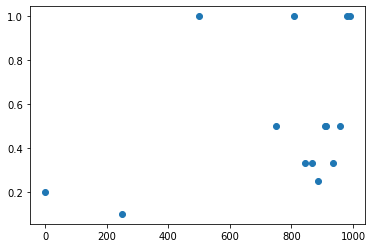

In [792]:
### Note: the LSS + BLiP will vary a little bit because
### I haven't found a good way to set the seed for the
### underlying cython code.
print_output(lss_blip_detections, beta)
create_gsizes_output(lss_blip_detections, signals, plot=True)

In [759]:
# 3. BH
crt_model = blip_sims.crt.MultipleDCRT(y=y, X=X, Sigma=cov, screen=True)
crt_model.multiple_pvals(levels=8, max_size=20, verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [05:44<00:00,  4.58it/s]


(True, [500])


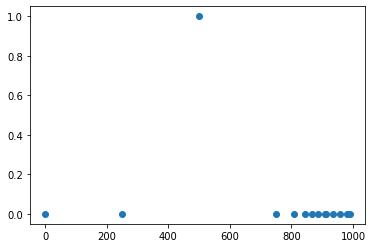

In [760]:
fbh_rej, _ = crt_model.pTree.tree_fbh(q=0.1)
print_output(fbh_rej, beta)
create_gsizes_output(fbh_rej, signals, plot=True)

(True, [500])


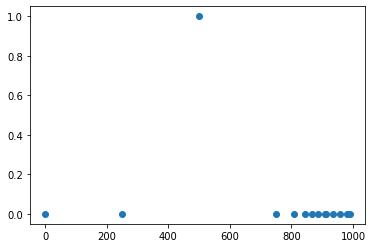

In [761]:
bh_rej, _ = crt_model.pTree.leaf_bh(q=0.1)
print_output(bh_rej, beta)
create_gsizes_output(bh_rej, signals, plot=True)

In [762]:
%%time
# 4. DAP-G
# create a directory for scratch files 
dap_prefix = blip_sims.utilities.create_dap_prefix(
    today='01-01-1900',
    hour='00-00-00',
)
pi1 = str(len(signals) / p)
msize = str(len(signals) * 1.1)
dap_out = blip_sims.dap.run_dap(
    X=X, y=y, file_prefix=dap_prefix, pi1=pi1, q=q, msize=msize
)

CPU times: user 1.44 s, sys: 787 ms, total: 2.23 s
Wall time: 2min 58s


(True, [465, 470, 472, 474, 476, 477, 478, 479, 480, 481, 482, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 529, 532])
(True, [831, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 905])


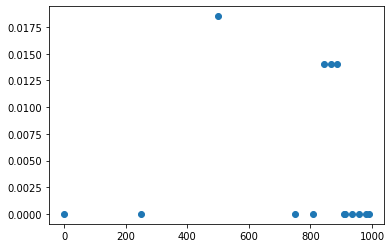

In [763]:
dap_rej, _, _ = dap_out
print_output(dap_rej, beta)
create_gsizes_output(dap_rej, signals, plot=True)

In [764]:
set(dap_rej[1]).intersection(set(signals))

{845, 868, 887}

In [765]:
len(dap_rej[1])

71

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 3.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/example_discoveries.png


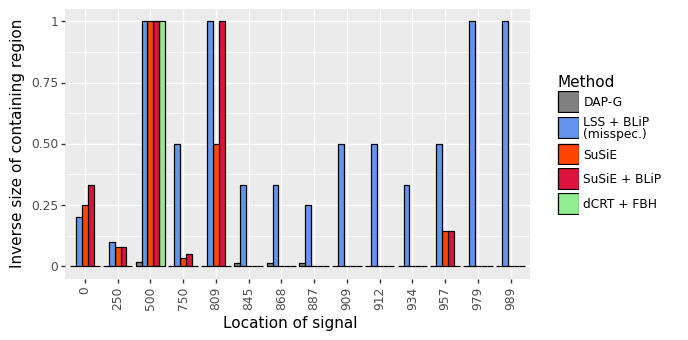

In [795]:
methods = ['LSS + BLiP\n(misspec.)', 'SuSiE', 'SuSiE + BLiP', 'DAP-G', 'dCRT + FBH']#, 'dCRT + BH']
df = pd.DataFrame(index=signals, columns=methods)
for method, detections in zip(
    methods, 
    [lss_blip_detections, 
     susie_sets, 
     susie_blip_detections,
     dap_rej,
     fbh_rej,
     #bh_rej,
    ]
):
    df[method] = create_gsizes_output(detections, signals)
    
    
colors = [
    'gray',
    'cornflowerblue', # LSS + BLiP (misspec)
    'orangered', #"susie"
    'crimson', #"susie + BLiP",
    'lightgreen', # BH
    'darkgreen', # FBH
]

dfm = df.reset_index().melt(id_vars=['index'], var_name='Method', value_name='inv_gsize')
dfm['index'] = pd.Categorical(dfm['index'], categories=df.index, ordered=True)
g = (
    ggplot(dfm, aes(color='Method', fill='Method', x='index', y='inv_gsize')) +    
    geom_col(position='dodge', color='black') + 
    theme(axis_text_x=element_text(angle = 90)) + 
    scale_fill_manual(colors) +
    labs(y="Inverse size of containing region", x="Location of signal") +
    theme(figure_size=(6,3.5))
    
)
g.save("final-plots/appendixsims/example_discoveries.png")
print(g)


<a id='changepoint_ex'></a>
## 1(d) Changepoint detection examples in appendix

### Susie convergence example

The Susie CS are: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}]


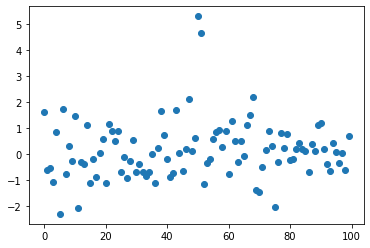

In [291]:
# Replicated from susie hard convergence example
np.random.seed(1)
T = 100
toy_x = np.random.randn(T)
toy_x[50:52] += 5
plt.scatter(np.arange(T), toy_x)
susie_alphas, susie_cs = blip_sims.susie.run_susie_trendfilter(
    toy_x, order=0, L=10, q=0.1
)
print("The Susie CS are:", [set(x) for x in susie_cs])

In [292]:
X = np.ones((T, T-1))
for j in range(T-1):
    X[0:(j+1), j] = 0

In [293]:
lm = pyblip.linear.LinearSpikeSlab(X=X, y=toy_x)
lm.sample(N=10000, chains=5)
inclusions = lm.betas != 0
cand_groups = pyblip.create_groups.sequential_groups(inclusions)
toy_blip_output = pyblip.blip.BLiP(cand_groups=cand_groups, q=0.1)

BLiP problem has 374 groups in contention, with 51 active features/locations


### Harder toy example

In [5]:
np.random.seed(111)
coeff_size = 2
sparsity = 0.04
T = 200
X, Y, beta = blip_sims.gen_data.gen_changepoint_data(
    T=T, coeff_size=coeff_size, sparsity=sparsity, coeff_dist='uniform'
)

In [14]:
def plot_changepoint_results(Y, beta, detections, susie_detections=None, title=None):
    fig, ax = plt.subplots(figsize=(6,2))
    plt.scatter(np.arange(T), Y, color='blue')
    plt.plot(np.arange(T), np.cumsum(beta), color='red')
    nnulls = set(np.where(beta != 0)[0].tolist())
    minlen = min([len(cs) for cs in detections])
    for j, cs in enumerate(detections):
        if len(nnulls.intersection(cs)) > 0:
            color = 'green'
        else:
            color = 'orange'
        ax.axvspan(min(cs), max(cs), alpha=minlen / len(cs), color=color, label='BLiP' if j == 0 else None)
    if susie_detections is not None:
        for j,cs in enumerate(susie_detections):
            if len(nnulls.intersection(cs)) > 0:
                color = 'blue'
            else:
                color = 'orange'
        ax.axvspan(min(cs), max(cs), alpha=minlen / len(cs), color=color, label='BLiP' if j == 0 else None)
    ax.set(title=title, xlabel='Time', ylabel='Y')
    return fig

BLiP problem has 1248 groups in contention, with 164 active features/locations
LP had 2 non-integer solutions across 14 locations. Binarizing using deterministic=True.
Long-step dual simplex will be used


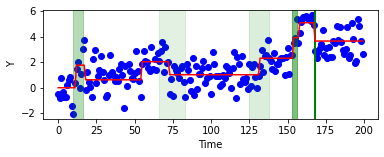

In [17]:
# lm = pyblip.linear.LinearSpikeSlab(
#     X=X, y=Y, p0=1-sparsity, update_p0=False, sigma2=1, update_sigma2=False, tau2=coeff_size, update_tau2=False
# )
# lm.sample(N=20000, chains=5, burn=100)
# inclusions = lm.betas != 0
# inclusions[:, 0] = 0
cand_groups = pyblip.create_groups.sequential_groups(inclusions, max_size=20)
blip_output = pyblip.blip.BLiP(cand_groups=cand_groups, q=0.05)
fig = plot_changepoint_results(
    Y, beta, 
    [x.group for x in blip_output],
)

plt.savefig("presentation_plots/section3/cp_hard_toy_ex.png")
plt.show()

### Combined plot

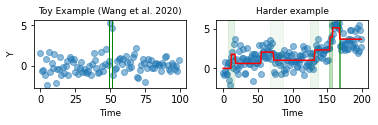

In [315]:
fig, axes = plt.subplots(1, 2, figsize=(6,1.25))
# Susie toy example
axes[0].scatter(np.arange(len(toy_x)), toy_x, alpha=0.5)
for j, signal in enumerate(toy_blip_output):
    cs = signal.group
    axes[0].axvspan(
        min(cs), max(cs), 
        alpha=1,
        color='green'
    )
    
# This will plotnothing since since susie makes no real discoveries
for cs in susie_cs:
    if len(cs) <= 25:
        ax.axvspan(min(cs), max(cs), alpha=0.5, color='orange', label='Susie')
        
# Harder example
axes[1].scatter(np.arange(len(Y)), Y, alpha=0.5)
axes[1].plot(np.arange(len(beta)), np.cumsum(beta), color='red')
detections = [x.group for x in blip_output]
nnulls = set(np.where(beta != 0)[0].tolist())
minlen = min([len(cs) for cs in detections]) / 2
for j, cs in enumerate(detections):
    if len(nnulls.intersection(cs)) > 0:
        color = 'green'
    else:
        color = 'orange'
    axes[1].axvspan(min(cs), max(cs), alpha=minlen / len(cs), color=color, label='BLiP' if j == 0 else None)
    
axes[0].set_title("Toy Example (Wang et al. 2020)", size=9)
axes[1].set_title("Harder example", size=9)
for j in [0,1]:
    axes[j].set_xlabel('Time', size=9)
axes[0].set_ylabel('Y', size=9)

plt.savefig("final-plots/section3/cp_exes.png", dpi=500, bbox_inches='tight')

<a id='misc_ex'></a>
## 1(e) Miscallaneous examples plots for presentations

### Manhattan Plot Example

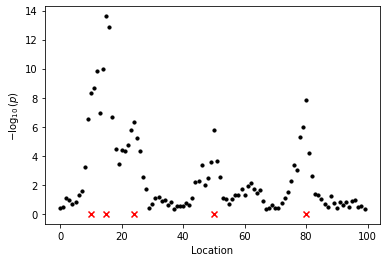

In [9]:
np.random.seed(12345)
import scipy.linalg
n, p, rho = 500, 100, 0.8
c = np.cumsum(np.zeros(p) + np.log(rho)) - np.log(rho)
cov = scipy.linalg.toeplitz(np.exp(c))
X = np.dot(np.random.randn(n, p), np.linalg.cholesky(cov).T)

# Sparse coefficients
beta = np.zeros(p)
signals = [10,15,24,50,80]
beta[signals] = 0.2 #* np.random.binomial(1, 0.5, size=len(signals))
y = np.random.randn() + np.dot(X, beta)


XTY = np.dot(X.T, y)
Xl2 = np.diag(np.dot(X.T, X))
Zscore = np.abs(XTY) / np.sqrt(Xl2)
pval = 1 - stats.norm.cdf(Zscore)
plt.scatter(np.arange(p), -1*np.log10(pval), color='black', s=10)
xval = 0 # np.min(-1*np.log10(pval))-0.1
plt.scatter(signals, [xval for _ in signals], marker='x', color='red')
plt.xlabel('Location')
plt.ylabel(r'$-\log_{10}(p)$')
plt.savefig("presentation_plots/examples/manhattan_plot.png", dpi=500)
plt.show()

In [10]:
# Run BLiP
np.random.seed(123)
lm = pyblip.linear.LinearSpikeSlab(X=X, y=y)
lm.sample(N=10000, chains=5)
cand_groups = pyblip.create_groups.sequential_groups(samples=lm.betas)

In [11]:
detections = pyblip.blip.BLiP(
    cand_groups=cand_groups, 
    q=0.01, 
    error='fdr',
    weight_fn='log_inverse_size'
)

BLiP problem has 1154 groups in contention, with 100 active features/locations
LP had 2 non-integer solutions across 1 locations. Binarizing with deterministic=True.


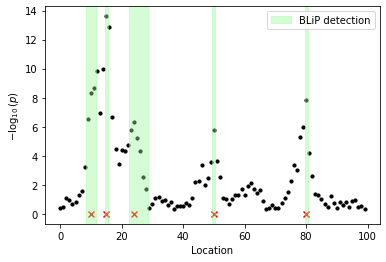

In [12]:
plt.scatter(np.arange(p), -1*np.log10(pval), color='black', s=10)
xval = 0 # np.min(-1*np.log10(pval))-0.1
plt.scatter(signals, [xval for _ in signals], marker='x', color='red')
plt.xlabel('Location')
plt.ylabel(r'$-\log_{10}(p)$')
for j, detection in enumerate(detections):
    plt.axvspan(
        min(detection.group) - 1/2, max(detection.group) + 1/2, 
        color='palegreen', label='BLiP detection' if j == 0 else None, 
        alpha=0.4
    )
plt.legend()
plt.savefig("presentation_plots/examples/manhattan_plot_blip.png", dpi=500)
plt.show()

### Changepoint example

In [13]:
# Generate data
np.random.seed(123) # original good one
T = 100
delta = 0.75 # original: 1.75
X = np.arange(T)
Y = np.random.randn(T)
Y[int(T/2):] += delta
mu = np.zeros(T)
mu[int(T/2):] += delta

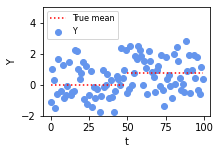

In [8]:
# Plot #2
fig, ax = plt.subplots(figsize=(3,2))
ax.scatter(X, Y, label='Y', color='#6495ED')
ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
    color='red',
    label='True mean',
    linestyle='dotted'
)
ax.plot(X[int(T/2):], mu[int(T/2):],
    color='red',
    linestyle='dotted'
)
ax.set(ylabel='Y', xlabel='t')
ax.set_ylim(-2, 5)
ax.legend(loc=(2), prop={'size': 8})
#plt.show()
plt.savefig("final-plots/changepoint_example.png", dpi=500)

### Astro Example

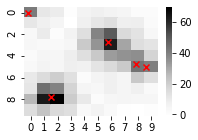

In [10]:
import scipy.signal 

# Create x, y
p = 10
z = np.zeros((p, p))
x = np.arange(p).reshape(-1, 1)
x = np.repeat(x, p, axis=1)
y = x.T

# Create point sources
np.random.seed(110)
# k = 15
# xsource = 10*np.random.uniform(size=(k,))
# ysource = 10*np.random.uniform(size=(k,))
# magsource = 20 + np.abs(10*np.random.randn(k))


xsource = [0.5, 8.25, 5.234, 5.5398, 3.234097]
ysource = [0.25, 2, 8.357098, 9.12309, 6.2509]
magsource = [50, 100, 35, 25, 83]

# Create means 
mu = z.copy()
for (i, j, mag) in zip(xsource, ysource, magsource):
    d = np.sqrt(np.power(i-x-0.5, 2) + np.power(j-y-0.5,2))
    mu += mag * np.exp(-1*d)


# Create data
D = np.sqrt(mu) * np.random.randn(p, p) + mu #3*np.random.randn(p, p) + mu

# Plot
fig, ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(D, cmap='Greys', ax=ax)
ax.scatter(ysource, xsource, color='red', marker='x', label='True Sources')
#ax.legend(bbox_to_anchor=(1.1, 1.3))
plt.savefig("final-plots/astro_example.png", dpi=500)

<a id='sims'></a>
# 2. Plots from simulation results

<a id='nearopt'></a>
## 2.1 Plots showing BLiP is verifiably nearly optimal

In [38]:
days = ['2022-02-26']
ts = ['05-02-09']
data = []
for d, t in zip(days, ts):
    df = pd.read_csv(f"data/lp_int_sol/{d}/{t}/results.csv")
    data.append(df)
data = pd.concat(data, axis='index')
data['Error'] = data['error'].map(
    {"fdr":"FDR", "pfer":"PFER", "fwer":"FWER", "local_fdr":"Local\nFDR"}
)
data = data.loc[data['kappa'] > 0.05]
data['num_nonint'] = data['n_singleton'] + 2 * data['n_rand_pairs']
id_vars = ['kappa','Error']

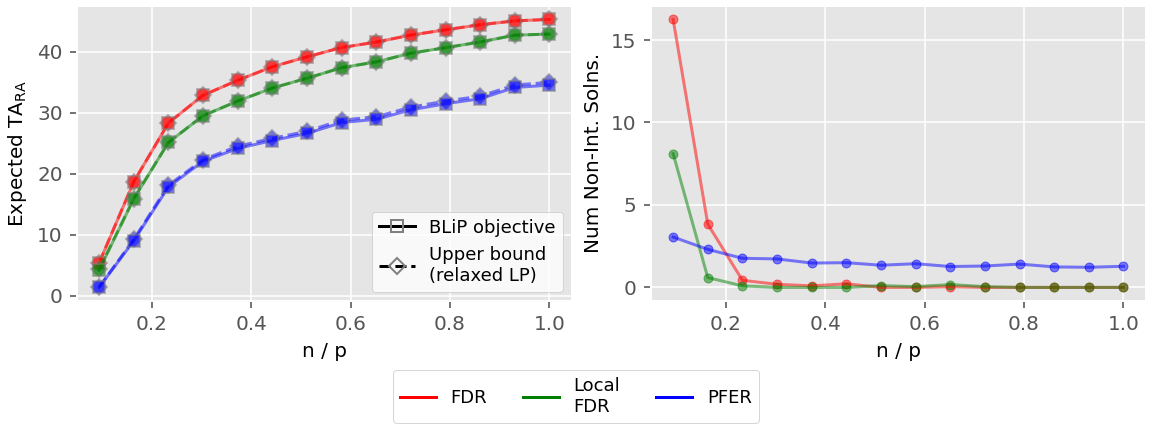

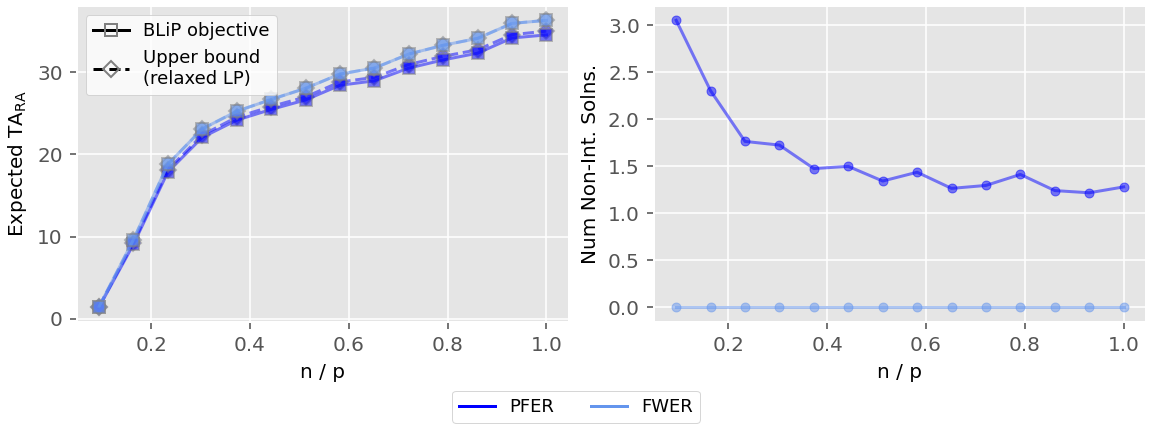

In [39]:
agg = calc_mean_sem(
    data, group_vals=['kappa', 'Error'],
    meas=['num_nonint', 'epower_lp', 'epower_ilp']
    
)

# unique values for left-hand plot
linetype_dict = {'epower_lp':'dashed', 'epower_ilp':'solid'}
marker_dict = {'epower_lp':'D', 'epower_ilp':'s'}
marker_kwargs = dict(
    markeredgecolor='gray',
    markersize=6,
    alpha=0.5,
)

errors = set(agg['Error'].unique())
color_dict = {'FDR':'red', 'FWER':'cornflowerblue', 'Local\nFDR':"green", 'PFER':"blue"}


# repeat for both main text and appendix
plt.style.use('ggplot')
for to_exclude, suffix in zip([set(['FWER']), set(['FDR', 'Local\nFDR'])], ['','_fwer']):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
    # Loop through and create lines
    for error in set(errors) - to_exclude:
        # lines for left plot
        sub = agg.loc[(agg['Error'] == error)]
        for meas in linetype_dict.keys():
            axes[0].plot(
                sub['kappa'], sub[meas+"_mean"], 
                linestyle=linetype_dict[meas],
                color=color_dict[error],
                marker=marker_dict[meas],
                **marker_kwargs,
            )
            
        # create lines for right plot
        axes[1].plot(
            sub['kappa'], sub["num_nonint_mean"], alpha=0.5,
            color=color_dict[error],
        )
        axes[1].scatter(
            sub['kappa'], sub["num_nonint_mean"], 
            marker='o',
            alpha=0.5,
            color=color_dict[error],
            s=20,
        )
        
    # Labels
    axes[1].set(ylabel='Num Non-Int. Solns.')
    axes[0].set(ylabel=r"Expected TA$_{\mathrm{RA}}$")
    axes[0].set(xlabel="n / p"); axes[1].set(xlabel="n / p")
    
    # Left legend
    left_handles = []
    for meas, label in zip(
        ['epower_ilp', 'epower_lp'],
        ['BLiP objective', 'Upper bound\n(relaxed LP)']
    ):
        left_handles.append(
            Line2D(
                [0], [0], label=label, color='black', 
                marker=marker_dict[meas],
                linestyle=linetype_dict[meas],
                markerfacecolor="None",
                alpha=1,
                markersize=6, markeredgecolor='gray',
            )
        )
    left_legend = axes[0].legend(
        handles = left_handles, fontsize=9, facecolor='white',
    )
    
    err_sub = set(errors) - to_exclude
    posits = ['left', 'right', 'center']
    error_handle = []
    for error, pos in zip(list(err_sub), posits):
        error_handle.append(Line2D(
            [0], [0], label=error, color=color_dict[error], 
            linestyle='solid',
        ))

    under_legend = fig.legend(
        handles=error_handle, 
        loc=f'outside lower center',
        ncol=len(error_handle),
        fontsize=9,
        facecolor='white',
    )
    plt.savefig(
        f"final-plots/section2/objective_gap{suffix}.png", dpi=500, bbox_inches='tight'
    )
    plt.show()


In [42]:
def rand_pair_plot_standalone(data):
    var_dict = {
        'n_singleton':'Other non-integers', 'n_rand_pairs':'Randomized pairs'
    }
    mdata = pd.melt(
        data[id_vars + ['n_rand_pairs', 'n_singleton']],
        id_vars=id_vars,
        var_name='variable',
        value_name='value'
    )
    mdata['variable'] = mdata['variable'].map(var_dict)
    agg_df = calc_mean_sem(
        mdata, group_vals=id_vars + ['variable'], meas=['value']
    )
    g = (
    ggplot(
        agg_df.loc[agg_df['Error'] != 'FWER'], aes(
            x='kappa', 
            y='value_mean', 
            color='variable',
            linetype='Error',
            shape='Error'
        )
    )
    + geom_point(alpha=0.5)
    + geom_line(alpha=0.5)
    + geom_errorbar(aes(ymin="value_ymin", ymax="value_ymax"), width=0.01)
    #+ facet_wrap("~covmethod")
    + labs(x=r'n / p', y='Average Count', color='Variable')
    + theme(
        figure_size=(5,2.5),
        axis_text_x=element_text(angle=35),
    )
    + scale_x_continuous(breaks=(0.1,0.25,0.5,0.75,1.0))
    + scale_color_manual(['red', 'blue'])

    )
    g.save("final-plots/section2/randomization_counts.png", dpi=500)
    print(g)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: final-plots/section2/randomization_counts.png


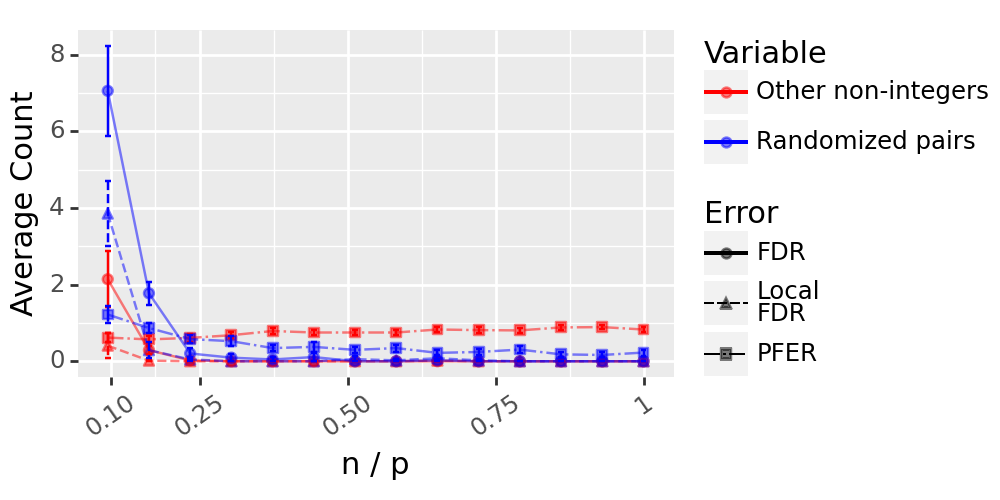

In [43]:
rand_pair_plot_standalone(data)

<a id='mainsim'></a>
## 2.2 Main simulations: variable selection in high-dimensional linear regression

In [986]:
job_ids = [
    '23857517', '23867138', '23866927', '23971173', '23971188', '23971219', 
    '24012189', '24012392'
] 
data = []
for job_id in job_ids:
    # read all data
    fnames = glob.glob(f"data/glms/*/*/results_id{job_id}*.csv")
    df = []
    for fname in tqdm(fnames):
        df.append(pd.read_csv(fname))
    df = pd.concat(df, axis='index')
    data.append(df)
    
# final concatenation
data = pd.concat(data, axis='index')
data['power'] = 100 * data['power'] / (data['p'] * data['sparsity'])
data['ntd'] = 100 * data['ntd'] / (data['p'] * data['sparsity'])

# Change method names
data['method'] = data['method'].str.replace('dap-g', 'DAP-G')
data['method'] = data['method'].str.replace('susie', 'SuSiE')
data['method'] = data['method'].str.replace('CRT', 'dCRT')
data['method'] = data['method'].str.replace('(indiv only)', '\n(indiv. only)', regex=False)

# cgroups
data.loc[data['cgroups'].isnull(), 'cgroups'] = "NA"

# get rid of dummy rows with only 10 MCMC samples
data = data.loc[data['nsample'] != 10]
data = data.loc[data['kappa'] <= 2.01]
data = data.loc[data['sparsity'] != 0.02]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.15it/s]


### Power/FDR plot for main text

/tmp/ipykernel_5948/896197708.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_sparsity_hdim.png


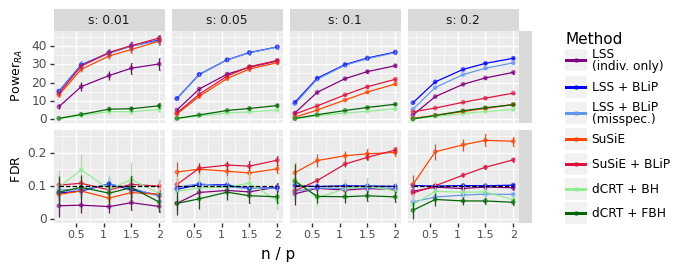

In [987]:

# Drop nfd, not needed and complicates melting
data0 = data.copy().drop("nfd", axis='columns')
data0 = data0.loc[data0['cgroups'] != 'all_pure']
# Melt for FDR/Power in 1 graph
data0 = data0.melt(
    id_vars=[c for c in data0.columns if c not in ['power', 'fdr', 'ntd']],
    var_name='Measurement'
)

data0['total_time'] = data0['model_time'] + data0['blip_time']

agg0 = calc_mean_sem(
    data0,
    group_vals=[
        'method', 'cgroups', 'y_dist', 'covmethod', 'kappa', 'p',
        'Measurement', 'sparsity', 'k', 'well_specified'],
    meas=['model_time', 'value', 'blip_time', 'total_time']
)
agg0['y_dist'] = agg0['y_dist'].astype(str)
agg0['kappa'] = np.around(agg0['kappa'], 2)

def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']

agg0['Method'] = agg0.apply(row2method, axis='columns')
agg0['s'] = "s: " + agg0['sparsity'].astype(str)

agg = agg0.loc[agg0['Measurement'] != 'ntd']
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})
sub = agg.loc[
    ((~(agg['Method'].str.contains("LSS"))) | (agg['cgroups'] == 'all')) |
    ((agg['Method'].str.contains("indiv")) & (~agg['Method'].str.contains("misspec.")))
]
sub = sub.loc[
    ~(sub['Method'].str.contains("DAP") | sub['Method'].str.contains("Yekutieli"))
]


colors = [
    'purple', # LSS (indiv only)
    'blue', # LSS + BLiP 
    'cornflowerblue', # LSS + BLiP (misspec)
    'orangered', #"susie"
    'crimson', #"susie + BLiP",
    'lightgreen', # dCRT + FBH
    'darkgreen', # dCRT + BH
]
methods = sorted(sub['Method'].unique())
method2color = {method:color for method, color in zip(methods, colors)}
method2color['DAP-G'] = 'gray' # for later
method2color['dCRT + Yekutieli'] = 'purple' # for future plots


meas = 'value'
g =  (
    ggplot(
        sub,
        aes(
            x='kappa', y=f'{meas}_mean',
            ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(size=1, alpha=0.5)
    + geom_errorbar(width=0.01)
    + facet_grid("meas~s", scales='free', labeller='label_value')
    + labs(
        x='n / p',
        y=r'     FDR              Power$_{RA}$',
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5), # make (6,2.5) for paper
        axis_title_y=element_text(size=9),
        axis_text_x=element_text(size=8),
    )
    + scale_color_manual(method2color)
)
qline = agg.loc[
    (agg['method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x='kappa',
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
    )
g.save("final-plots/section3/linear_sparsity_hdim.png", dpi=500)
print(g)

### Frequency plot for main text

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_hdim_freq.png


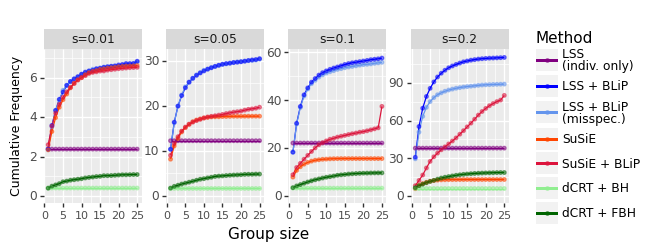

In [988]:
data0 = data.loc[
    (data['kappa'] == 1.1) &
    (data['cgroups'] != 'all_pure')
]
group_vals = [
    'method', 'covmethod', 'cgroups',
    'kappa', 'p', 'sparsity', 'well_specified',
]
freq_meas = [f'ntd_le_{j+1}' for j in range(25)]
data0 = data0[group_vals + freq_meas].melt(
    id_vars=group_vals,
    value_name='ntd', 
    var_name='gsize',
)
data0['gsize'] = data0['gsize'].apply(lambda x: int(x.split("_")[-1]))
agg0 = calc_mean_sem(
    data0,
    group_vals=group_vals + ['gsize'],
    meas=['ntd']
)

# processing
agg0['Method'] = agg0.apply(row2method, axis='columns')
agg0['s'] = "s=" + agg0['sparsity'].astype(str) 
#agg0['s'] = agg0['s'] +r" ($|\mathcal{S}|=$"  + (agg0['sparsity'] * agg0['p']).astype(int).astype(str) + ")"
#agg0['s'] = r"$|\mathcal{S} |=$" + (agg0['sparsity'] * agg0['p']).astype(int).astype(str) 
#svals = agg0['s'].unique()
#svals = sorted(svals, key = lambda x: float(x.split("=$")[-1]))
#agg0['s'] = pd.Categorical(agg0['s'], categories=svals, ordered=True)

sub = agg0.loc[
    ((~(agg0['Method'].str.contains("LSS"))) | (agg0['Method'].str.contains("BLiP"))) |
    ((agg0['Method'].str.contains("indiv")) & (~agg0['Method'].str.contains("misspec.")))
]
sub = sub.loc[
    ~(sub['Method'].str.contains("DAP") | sub['Method'].str.contains("Yekutieli"))
]

g =  (
    ggplot(
        sub,
        aes(
            x='gsize', y=f'ntd_mean', ymin=f'ntd_ymin', ymax=f'ntd_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(size=1, alpha=0.5)
    #+ geom_errorbar(width=0.01)
    + facet_wrap("~s", scales='free', labeller='label_value', ncol=4)
    + labs(
        x='Group size',
        y='Cumulative Frequency',
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2), # make (6,2.5) for paper
        #legend_position=(1.01, 0.5),
        axis_title_y=element_text(size=9),
        axis_text_x=element_text(size=8),
        subplots_adjust={"wspace":0.25},
    )
    + scale_color_manual(method2color)
    + ylim(0, None)
)
g.save("final-plots/section3/linear_hdim_freq.png", dpi=500)
print(g)

### Appendix with DAP-G, dCRT + Yekutieli

/tmp/ipykernel_5948/391617483.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_sparsity_hdim_extras.png


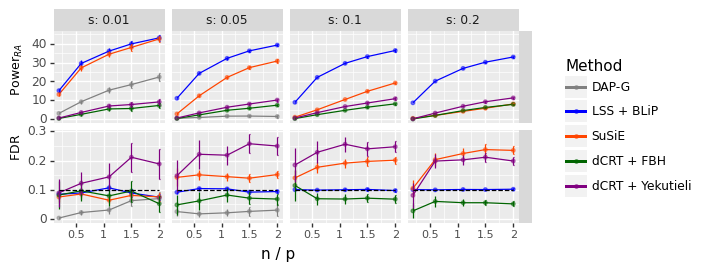

In [989]:
# Drop nfd, not needed and complicates melting
data0 = data.copy().drop("nfd", axis='columns')
# Melt for FDR/Power in 1 graph
data0 = data0.melt(
    id_vars=[c for c in data0.columns if c not in ['power', 'fdr', 'ntd']],
    var_name='Measurement'
)

data0['total_time'] = data0['model_time'] + data0['blip_time']

agg0 = calc_mean_sem(
    data0,
    group_vals=[
        'method', 'y_dist', 'covmethod', 'kappa', 'p',
        'Measurement', 'sparsity', 'k', 'well_specified'],
    meas=['model_time', 'value', 'blip_time', 'total_time']
)
agg0['y_dist'] = agg0['y_dist'].astype(str)
agg0['kappa'] = np.around(agg0['kappa'], 2)

def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']

agg0['Method'] = agg0.apply(row2method, axis='columns')
agg0['s'] = "s: " + agg0['sparsity'].astype(str)
agg = agg0.copy()

agg = agg0.loc[agg0['Measurement'] != 'ntd']
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})
sub = agg.loc[
    (agg['Method'].str.contains("DAP"))
    | (agg['Method'].str.contains("Yekutieli"))
    | (agg['Method'].str.contains("FBH"))
    | (agg['Method'] == 'SuSiE')
    | (agg['Method'] == 'LSS + BLiP')
]



g =  (
    ggplot(
        sub,
        aes(
            x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(size=1, alpha=0.5)
    + geom_errorbar(width=0.01)
    + facet_grid("meas~s", scales='free', labeller='label_value')
    + labs(
        x='n / p',
        y=r'            FDR          Power$_{RA}$',
    )
    + scale_color_manual(method2color)
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5), # make (6,2.5) for paper
        #legend_position=(1.01, 0.5),
        axis_title_y=element_text(size=9),
        axis_text_x=element_text(size=8),
    )
)
qline = agg.loc[
    (agg['method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x='kappa',
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
)
g.save("final-plots/section3/linear_sparsity_hdim_extras.png", dpi=500)
print(g)

## Appendix plots: purity analysis

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_purity_freq.png


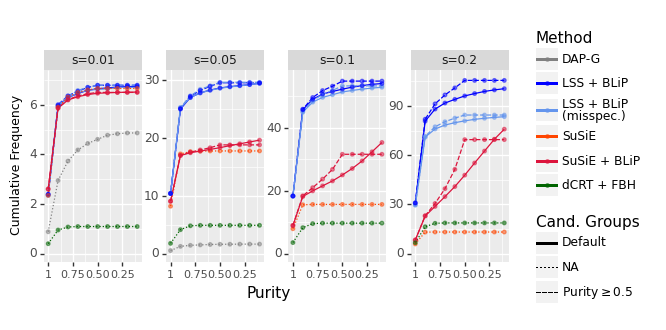

In [990]:
data0 = data.loc[data['kappa'] == 1.1].copy()
group_vals = [
    'method', 'covmethod', 
    'kappa', 'p', 'sparsity', 'well_specified',
    'cgroups',
]
PURITIES = np.round(np.flip(np.linspace(0.1, 1, 10)), 2)
purity_meas = [f'purity_ge_{pt}' for pt in PURITIES]
data0 = data0[group_vals + purity_meas].melt(
    id_vars=group_vals,
    value_name='ntd', 
    var_name='purity',
)
data0['purity'] = data0['purity'].apply(lambda x: float(x.split("_")[-1]))

agg0 = calc_mean_sem(
    data0,
    group_vals=group_vals + ['purity'],
    meas=['ntd']
)

# processing
agg0['Method'] = agg0.apply(row2method, axis='columns')
agg0['s'] = "s=" + agg0['sparsity'].astype(str) 
sub = agg0.loc[
    ~(agg0['Method'].str.contains("indiv"))
]
sub = sub.loc[
    #(~(sub['Method'].str.contains("DAP")) &
    (~sub['Method'].str.contains("Yekutieli")) &
    (~(sub['Method'].str.contains(" BH")))
]
sub['cgroups'] = sub['cgroups'].map({
    "all":"Default",
    "all_pure":r"Purity$\geq 0.5$",
})
sub.loc[~sub['Method'].str.contains("BLiP"), 'cgroups'] = 'NA'

g =  (
    ggplot(
        sub,
        aes(
            x='purity', y=f'ntd_mean', ymin=f'ntd_ymin', ymax=f'ntd_ymax',
            color='Method',
            linetype='cgroups',
        )
    ) 
    + geom_line()
    + geom_point(size=1, alpha=0.5)
    #+ geom_errorbar(width=0.01)
    + facet_wrap("~s", scales='free', labeller='label_value', ncol=4)
    + labs(
        x='Purity',
        y='Cumulative Frequency',
        linetype='Cand. Groups'
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5),
        #legend_position=(1.01, 0.5),
        axis_title_y=element_text(size=9),
        axis_text_x=element_text(size=8),
        subplots_adjust={"wspace":0.25},
    )
    + scale_x_reverse()
    + scale_color_manual(method2color)
    + scale_linetype_manual(['solid', 'dotted', 'dashed'])
    + ylim(0, None)
)
g.save("final-plots/section3/linear_purity_freq.png", dpi=500)

print(g)

In [991]:
for method in ['LSS + BLiP', 'LSS + BLiP\n(misspec.)']:
    num = sub.loc[
        (sub['Method'] == method) & (sub['purity'] == 0.50) &
        (sub['cgroups'] != 'all_pure')
    ].sort_values("sparsity")['ntd_mean'] 
    denom = sub.loc[
        (sub['Method'] == method) & (sub['purity'] == 0.1) &
        (sub['cgroups'] != 'all_pure')
    ].sort_values("sparsity")['ntd_mean']
    print(method, num.values / denom.values)

LSS + BLiP [0.98734177 1.         0.9725883  1.         0.96702982 1.
 0.95611938 1.        ]
LSS + BLiP
(misspec.) [0.98843931 1.         0.97151899 1.         0.97171332 1.
 0.96943799 1.        ]


/tmp/ipykernel_5948/3794859260.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_purity_power.png


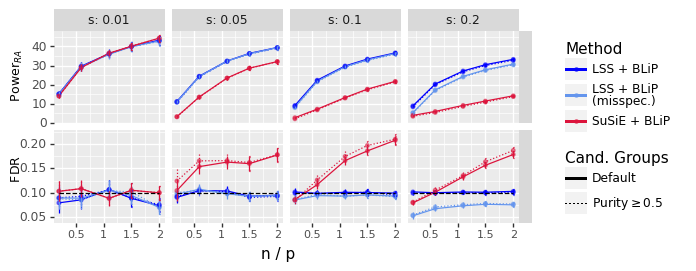

In [992]:
data0 = data.copy()
# Melt for FDR/Power in 1 graph
data0 = data0.melt(
    id_vars=[c for c in data0.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)

agg0 = calc_mean_sem(
    data0,
    group_vals=[
        'method', 'cgroups', 'y_dist', 'covmethod', 'kappa', 'p',
        'Measurement', 'sparsity', 'k', 'well_specified'
    ],
    meas=['value']
)
agg0['y_dist'] = agg0['y_dist'].astype(str)
agg0['kappa'] = np.around(agg0['kappa'], 2)

def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']

agg0['Method'] = agg0.apply(row2method, axis='columns')
agg0['s'] = "s: " + agg0['sparsity'].astype(str)

agg = agg0.loc[agg0['Measurement'] != 'ntd']
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})
sub = agg.loc[
    agg['Method'].str.contains("BLiP")
]
sub['cgroups'] = sub['cgroups'].map({
    "all":"Default",
    "all_pure":r"Purity$\geq 0.5$",
})

colors = [
    'blue', # LSS + BLiP 
    'cornflowerblue', # LSS + BLiP (misspec)
    'crimson', #"susie + BLiP",
]

meas = 'value'
g =  (
    ggplot(
        sub,
        aes(
            x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method',
            linetype='cgroups',
        )
    ) 
    + geom_line()
    + geom_point(size=1, alpha=0.5)
    + geom_errorbar(width=0.01)
    + facet_grid("meas~s", scales='free', labeller='label_value')
    + labs(
        x='n / p',
        y=r'     FDR              Power$_{RA}$',
        linetype='Cand. Groups'
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5),
        axis_title_y=element_text(size=9),
        axis_text_x=element_text(size=8),
    )
    + scale_color_manual(colors)
    + scale_linetype_manual(['solid', 'dotted'])
)
qline = agg.loc[
    (agg['method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x='kappa',
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
    )
g.save("final-plots/section3/linear_purity_power.png", dpi=500)
print(g)

<a id='varyp'></a>
## 2.3 A high-dimensional regime where n, p grow linearly

#### Attempt 2 (better)

In [12]:
day = '2022-01-06'
t = '13-00-20' 

data = pd.read_csv(f"data/glms/{day}/{t}/results.csv")
data['power'] = 100 * data['power'] / (data['sparsity'] * data['p']) 
data['method'] = data['method'].str.replace('susie', 'SuSiE')

def row2method1(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        return row['method'] + f"\n(niter={5*row['nsample']})"
    return row['method']

group_vals=['method', 'y_dist', 'covmethod', 'kappa', 'p', 'sparsity', 'k', 'nsample']

agg = calc_mean_sem(
    data,
    group_vals=group_vals,
    meas=['model_time', 'power', 'fdr', 'blip_time']
)
agg['kappa'] = np.around(agg['kappa'], 2)
agg['Method'] = agg.apply(row2method1, axis='columns')

In [13]:
data2 = data[group_vals + ['model_time', 'blip_time']]
data2 = pd.melt(
    data2,
    id_vars=group_vals,
    var_name='Type',
    value_name='Time'
)
data2 = data2.loc[data2['Time'] != 0]
agg2 = calc_mean_sem(
    data2,
    group_vals=group_vals + ['Type'],
    meas=[ 'Time'],
    trunc_zero=False
)

def row2method(row):
#     if row['Type'] == 'blip_time':
#         if 'LSS' in row['method']:
#             return f'BLiP (LSS {row["nsample"]})'
#         else:
#             return 'BLiP (SuSiE)'
#     else:
    if 'LSS' in row['method']:
        return f'LSS {row["nsample"]}'
    elif 'dap' in row['method']:
        return 'DAP'
    else:
        return 'SuSiE'
    
agg2['Method'] = agg2.apply(row2method, axis='columns')

In [1204]:
data3 = data.copy()
data3['total_time'] = data3['model_time'] + data3['blip_time']
data3 = data3[group_vals + ['model_time', 'total_time', 'blip_time']]
data3 = pd.melt(
    data3,
    id_vars=group_vals + ['blip_time'],
    var_name='Type',
    value_name='Time'
)
data3 = data3.loc[
    ((data3['blip_time'] != 0) | (data3['Type'] == 'model_time'))
    & (data3['method'].str.contains("BLiP"))
]
agg3 = calc_mean_sem(
    data3,
    group_vals=group_vals + ['Type'],
    meas=['Time'],
    trunc_zero=False
)

def row2method(row):
    if row['Type'] == 'model_time':
        suffix = ''
    else:
        suffix = ' + BLiP'
    if 'LSS' in row['method']:
        return f"LSS{suffix}" #f'LSS\n(niter={5*row["nsample"]})'
    else:
        return f'SuSiE{suffix}'
    
agg3['Method'] = agg3.apply(row2method, axis='columns')
agg3['Type'] = agg3['Type'].map(
    {'model_time':'Model only', 'total_time':'Total\n(Model+BLiP)'}
)
agg3 = agg3.loc[
    agg3['nsample'].isin([0, 10000])
]

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: presentation_plots/section3/linear_vp_time_v2.png


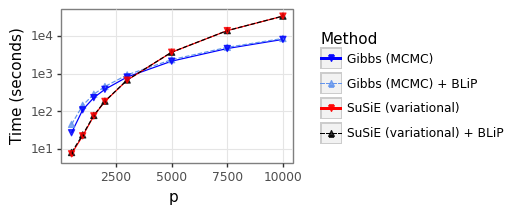

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_vp_time_v2.png


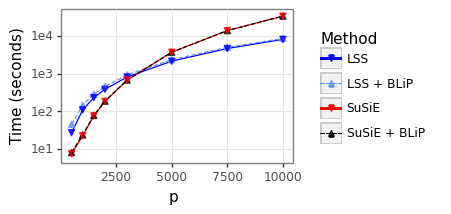

In [1206]:
meas = 'Time'
for final_dir in ['presentation_plots', 'final-plots']:
    sub = agg3.copy()
    if final_dir == 'presentation_plots':
        sub['Method'] = sub['Method'].str.replace(
            "SuSiE", "SuSiE (variational)"
        )
        sub['Method'] = sub['Method'].str.replace(
            "LSS", "Gibbs (MCMC)"
        )
    g =  (
        ggplot(
            sub,
            aes(
                x='p', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                color='Method', linetype='Method', shape='Method'
            )
        ) 
        + geom_line()#aes(linetype='Type'))
        + geom_point(size=2, alpha=0.8)#aes(shape='Type'), size=2, alpha=0.5)
        + geom_errorbar(width=0.01)
        + labs(
            x='p',
            y=f'{meas.capitalize()} (seconds)',
        )
        + scale_y_log10()
        + theme_bw()
        + theme(
            panel_grid_minor = element_blank(), 
            figure_size=(3,2)
        )
        #+ scale_color_manual([ 'forestgreen', 'purple', 'cornflowerblue', 'black'])
        + scale_color_manual(['blue', 'cornflowerblue', 'red', 'black'])
        #+ scale_fill_manual(['blue', 'red'])
        + scale_linetype_manual(['solid', 'dashed', 'solid', 'dashed'])
        + scale_shape_manual(['v', '^', 'v', '^'])
    )
    g.save(f"{final_dir}/section3/linear_vp_time_v2.png", dpi=500)
    print(g)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: presentation_plots/section3/linear_vp_power.png


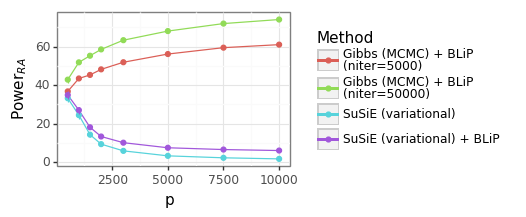

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: presentation_plots/section3/linear_vp_fdr.png


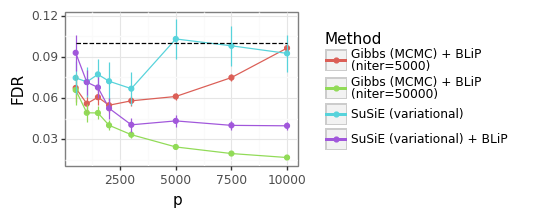

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_vp_power.png


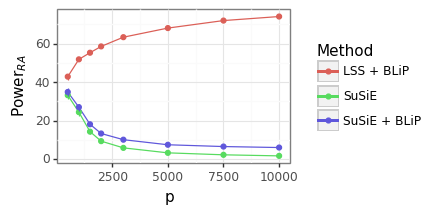

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/linear_vp_fdr.png


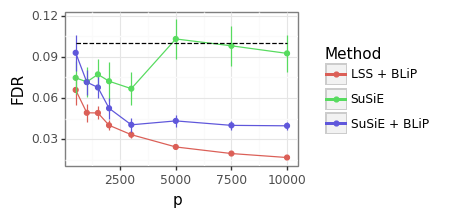

In [1210]:
for final_dir in ['presentation_plots', 'final-plots']:
    for meas in ['power', 'fdr']:
        sub = agg.copy()
        if final_dir == 'presentation_plots':
            sub['Method'] = sub['Method'].str.replace(
                "SuSiE", "SuSiE (variational)"
            )
            sub['Method'] = sub['Method'].str.replace(
                "LSS", "Gibbs (MCMC)"
            )
        else:
            sub = sub.loc[
                (sub['Method'].str.contains("50000")) | (~sub['Method'].str.contains("LSS"))
            ]
            sub['Method'] = sub['Method'].apply(lambda x: "LSS + BLiP" if "LSS" in x else x)
        g =  (
            ggplot(
                sub,
                aes(
                    x='p', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                    color='Method'
                )
            ) 
            + geom_line()
            + geom_point()
            + geom_errorbar(width=0.01)
            + labs(
                x='p',
                y=r'Power$_{RA}$' if meas == 'power' else 'FDR',
            )
            + theme_bw()
            + theme(figure_size=(3,2), strip_margin=0)
        )
        if meas == 'fdr':
            qline = agg.loc[agg['method'] == 'SuSiE'].copy()
            qline[f'{meas}_mean'] = 0.1
            g += geom_line(
                data=qline,
                mapping=aes(
                    x='p',
                    y=f'{meas}_mean'
                ),
                inherit_aes=False,
                color='black',
                linetype='dashed'
            )
        g.save(f"{final_dir}/section3/linear_vp_{meas}.png", dpi=500)
        print(g)



<a id='probit'></a>
## 2.4 Probit setting

In [14]:
# this includes everything except LSS, PSS + BLiP
days = [
    '2022-02-12', '2022-02-12', '2022-02-12',
    '2022-02-14', '2022-02-14', '2022-02-14',
]
ts = [
    '05-50-31', '05-51-20', '05-51-22',
    '04-24-13', '04-24-20', '04-27-07',
]

data_list = []
for day, t in zip(days, ts):
    data_list.append(pd.read_csv(f"data/glms/{day}/{t}/results.csv"))
data1 = pd.concat(data_list, axis='index')
data1 = data1.loc[
    ~((data1['method'].str.contains("LSS")) | (data1['method'].str.contains("PSS")))
]

In [15]:
# This data includes LSS / PSS + BLiP run correctly (with bsize=5)
# and also for p = 1000, it includes everything except CRT/DAP-G
days2 = ['2022-02-26', '2022-03-07']
ts2 = ['06-06-55', '04-03-07']
data_list2 = []
for day, t in zip(days2, ts2):
    data_list2.append(pd.read_csv(f"data/glms/{day}/{t}/results.csv"))
data2 = pd.concat(data_list2, axis='index')
data2 = data2.loc[
    (data2['method'].str.contains("LSS")) | (data2['method'].str.contains("PSS"))
]

In [16]:
data = pd.concat([data1, data2], axis='index')

In [17]:
data['power'] = 100 * data['power'] / (data['p'] * data['sparsity'])

# Change method names
data['method'] = data['method'].str.replace('dap-g', 'DAP-G')
data['method'] = data['method'].str.replace('susie', 'SuSiE')
data['method'] = data['method'].str.replace('CRT', 'dCRT')

# Drop nfd, not needed and complicates melting
data = data.drop("nfd", axis='columns')
data = data.loc[data['kappa'] > 0.1]

# Melt for FDR/Power in 1 graph
data = data.melt(
    id_vars=[c for c in data.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)

data['total_time'] = data['model_time'] + data['blip_time']

agg = calc_mean_sem(
    data,
    group_vals=[
        'method', 'y_dist', 'covmethod', 'kappa', 'p',  'coeff_size',
        'Measurement', 'sparsity', 'k', 'well_specified'],
    meas=['model_time', 'value', 'blip_time', 'total_time']
)
agg['y_dist'] = agg['y_dist'].astype(str)
agg['kappa'] = np.around(agg['kappa'], 2)

def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']

agg['Method'] = agg.apply(row2method, axis='columns')

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/probit_power_fdr.png


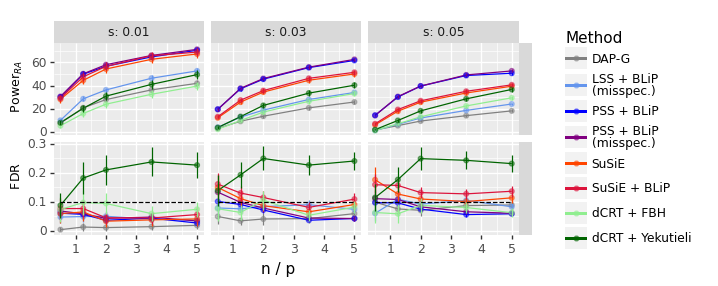

In [1164]:
colors = [
    'gray', # dap
    #'blue', # LSS + BLiP 
    'cornflowerblue', # LSS + BLiP (misspec)
    'blue', # PSS + BLiP 
    'purple', # PSS + BLiP (misspec)
    'orangered', #"susie"
    'crimson', #"susie + BLiP",
    'lightgreen', # FBH
    'darkgreen', # Yekutieli
]
methods = sorted(agg['Method'].unique())
method2color = {method:color for method, color in zip(methods, colors)}

agg['s'] = agg['sparsity'].astype(str)
#agg['s'] = "s: " + agg['sparsity'].astype(str)
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})

subset = agg.loc[agg['kappa'] < 6]

meas = 'value'
g =  (
    ggplot(
        subset,# & (agg['method'] == 'dap-g')],
        aes(
            x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(alpha=0.5)
    + geom_errorbar(width=0.001)
    + facet_grid("meas~s", scales='free', labeller='label_both')
    + labs(
        x=r'n / p',
        y=r'       FDR             Power$_{RA}$',
        #title=f'{reg_type} Regression on AR(5) design'
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5), # make (6,2.5) for paper
        axis_title_y=element_text(size=9),
        axis_text_x=element_text(size=9)
    )
    + scale_color_manual(method2color)
)
qline = subset.loc[
    (agg['method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x='kappa',
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
    )
g.save("final-plots/section3/probit_power_fdr.png", dpi=500)
print(g)


<a id='changepoint_sim'></a>
## 2.5 Changepoint simulations

### Main changepoint simulations

In [1187]:
# Load data
days = ['2022-02-01', '2022-02-01', '2022-02-01']
ts = ['20-42-00', '20-43-26', '20-44-48']
data = []
for d, t in zip(days, ts):
    data.append(pd.read_csv(f"data/changepoint/{d}/{t}/results.csv"))
data = pd.concat(data, axis='index')

# Mispecified setting
days2 = ['2022-02-14', '2022-02-14']
ts2 = ['06-12-33', '06-12-40']
data2 = []
for d, t in zip(days2, ts2):
    data2.append(pd.read_csv(f"data/changepoint/{d}/{t}/results.csv"))
data2 = pd.concat(data2, axis='index')
data2 = data2.loc[~data2['well_specified']]

# Combine
data = pd.concat([data, data2], axis='index')

# Preprocessing
data['s'] = data['sparsity']
data['power'] = 100*data['power'] / (data['p'] * data['s'])

# Change method names
data['method'] = data['method'].str.replace('susie', 'SuSiE')

# Drop nfd, not needed and complicates melting
data = data.drop("nfd", axis='columns')
# Melt for FDR/Power in 1 graph
# data = data.melt(
#     id_vars=[c for c in data.columns if c not in ['power', 'fdr']],
#     var_name='Measurement'
# )


group_vals=[
    'well_specified', 
    'Method', 
    'p', 
    'spacing', 
    'sparsity',
    'coeff_size',
    'nsample'
]

def row2method(row):
    if row['well_specified']:
        return row['method']
    return row['method'] + '\n(misspec)'
data['Method'] = data.apply(row2method, axis='columns')
data['Method'] = data['Method'].str.replace('susie', 'SuSiE')

agg = calc_mean_sem(
    data,
    group_vals=group_vals, #+ ['Measurement'],
    meas=['model_time', 'power', 'fdr', 'blip_time']
)
agg['s'] = "s: " + agg['sparsity'].astype(str)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/cp_power.png


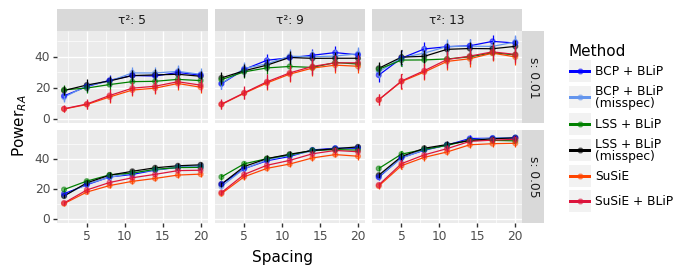

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/section3/cp_fdr.png


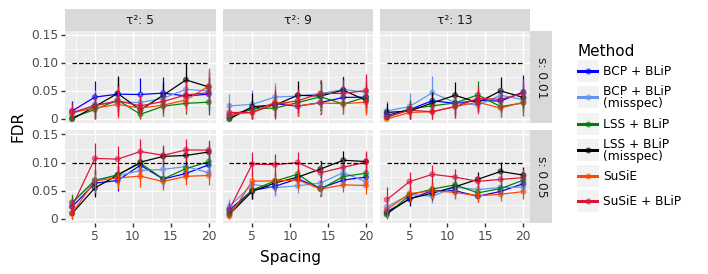

In [1188]:
def label_cp(x):
    if 's' in x:
        return x
    else:
        return f"τ²: {x}"
    
for meas in ['power', 'fdr']:
    g =  (
        ggplot(
            agg,
            aes(
                x='spacing', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                color='Method'
            )
        ) 
        + geom_line()
        + geom_point(alpha=0.5)
        + geom_errorbar(width=0.01)
        + facet_grid("s~coeff_size", scales='free', labeller=label_cp)
        + labs(
            x='Spacing',
            y='Power$_{RA}$' if meas == 'power' else 'FDR',
        )
        + theme(
            #strip_text_y=element_blank(),
            figure_size=(6,2.5), # make (6,2) for paper
        )
        + scale_color_manual(['blue', 'cornflowerblue', 'green', 'black', 'orangered', 'crimson'])
    )
    if meas == 'fdr':
        xeqy = agg.loc[agg['Method'] == 'SuSiE'].copy()
        xeqy['fdr_mean'] = 0.1
        xeqy['fdr_ymin'] = 0.1
        xeqy['fdr_ymax'] = 0.1
        g += geom_line(
            data=xeqy,
            linetype='dashed',
            color='black'
        )
        g += ylim(0, 0.15)
    else:
        g += ylim(0, None)

    g.save(f"final-plots/section3/cp_{meas}.png", dpi=500)
    print(g)

### Extra changepoint simulations

In [1189]:
# Load data
days = ['2022-03-07']
ts = ['03-51-35']
data = []
for d, t in zip(days, ts):
    data.append(pd.read_csv(f"data/changepoint/{d}/{t}/results.csv"))
data = pd.concat(data, axis='index')

# Preprocessing
data['s'] = data['sparsity']
data['power'] = 100*data['power'] / (data['p'] * data['s'])

# Change method names
data['method'] = data['method'].str.replace('susie', 'SuSiE')

# Drop nfd, not needed and complicates melting
data = data.drop("nfd", axis='columns')
# Melt for FDR/Power in 1 graph
data = data.melt(
    id_vars=[c for c in data.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)


group_vals=[
    'well_specified', 
    'Method', 
    'p', 
    'spacing', 
    'sparsity',
    'coeff_size',
    'nsample',
    'reversion_prob'
]

def row2method(row):
    if row['well_specified']:
        return row['method']
    return row['method'] + '\n(misspec)'
data['Method'] = data.apply(row2method, axis='columns')
data['Method'] = data['Method'].str.replace('susie', 'SuSiE')

agg = calc_mean_sem(
    data,
    group_vals=group_vals + ['Measurement'],
    meas=['model_time', 'value', 'blip_time']
)
agg['s'] = "s: " + agg['sparsity'].astype(str)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/cp_power_fdr.png


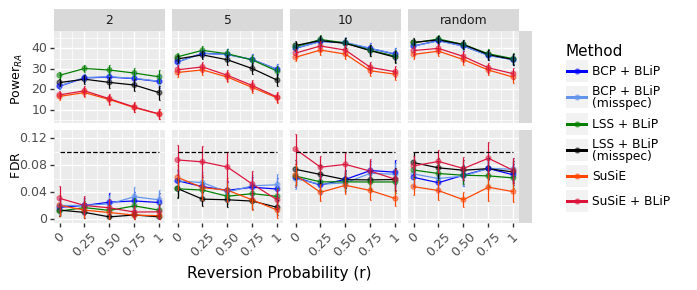

In [1190]:
meas = 'value'
x = 'reversion_prob'
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})
agg['spacing'] = pd.Categorical(
    agg['spacing'],
    categories=['2', '5', '10', 'random'],
    ordered=True,
)

g =  (
    ggplot(
        agg.loc[agg['coeff_size']==9],
        aes(
            x=x, y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(alpha=0.5)
    + geom_errorbar(width=0.01)
    + facet_grid("meas~spacing", scales='free', labeller='label_value')
    + labs(
        x="Reversion Probability (r)",
        y=r'     FDR            Power$_{RA}$',
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5),
        axis_title_y=element_text(size=9),
        axis_text_y=element_text(size=9),
        axis_text_x=element_text(size=9, angle=45)
    )
    + scale_color_manual(['blue', 'cornflowerblue', 'green', 'black', 'orangered', 'crimson'])
)
qline = agg.loc[
    (agg['Method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x=x,
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
)

g.save("final-plots/appendixsims/cp_power_fdr.png", dpi=500)
print(g)

<a id='mcmc'></a>
## 2.6 Robustness to MCMC convergence failures

In [28]:
days = ['2022-03-01', '2022-03-01']
ts = ['04-27-19', '13-46-01']

data = []
for d, t in zip(days, ts):
    df = pd.read_csv(f"data/convergence/{d}/{t}/results.csv")
    data.append(df)
data = pd.concat(data, axis='index')

# Update methods
def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']
data['Method'] = data.apply(row2method, axis='columns')
data['power'] = 100 * data['power'] / (data['p'] * data['sparsity'])

id_vars = [
    'Method', 'bsize', 'well_specified', 'nsample', 'chains', 'covmethod', 'kappa', 'p', 'sparsity', 'k'
]

# Create agg
agg = calc_mean_sem(
    data,
    group_vals=id_vars,# + ['Measurement'],
    meas=['power', 'fdr']
)
agg['sparsity'] = np.around(agg['sparsity'], 2).astype(str)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/manychains_power.png


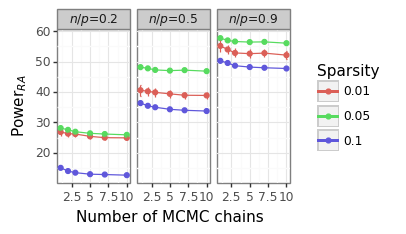

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/manychains_fdr.png


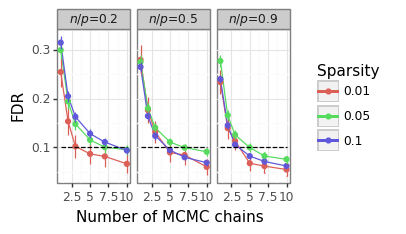

In [29]:
for meas in ['power', 'fdr']:
    g =  (
        ggplot(
            agg,
            aes(
                x='chains', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                color='sparsity'
            )
        ) 
        + geom_line()
        + geom_point()
        + geom_errorbar(width=0.01)
        + facet_wrap("~kappa", labeller=lambda x: str(fr"$n/p$={x}"))
        + labs(
            x='Number of MCMC chains',
            y='Power$_{RA}$' if meas == 'power' else 'FDR',
            color='Sparsity'
        )
        + theme_bw()
        + theme(figure_size=(3,2))
)
    
    if meas == 'fdr':
        qline = agg.loc[agg['Method'] == 'LSS + BLiP\n(misspec.)'].copy()
        qline[f'{meas}_mean'] = 0.1
        g += geom_line(
            data=qline,
            mapping=aes(
                x='chains',
                y=f'{meas}_mean'
            ),
            inherit_aes=False,
            color='black',
            linetype='dashed'
        )
    g.save(f"final-plots/appendixsims/manychains_{meas}.png", dpi=500)
    print(g)



<a id='susie'></a>
## 2.7 SuSiE alpha inspection plots

In [1194]:
def calc_mean_sem_alphas(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column. Same as the original function but accounts for the fact
    that some seeds may not have any values.
    """
    nreps = data['seed'].unique().shape[0]
    agg_df = data.groupby(group_vals)[meas].agg(['sum', 'std']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['sum'] / nreps
        agg_df[f'{m}_se'] = agg_df[m]['std'] / np.sqrt(nreps)
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

In [1195]:
days = ['2022-04-13', '2022-04-13', '2022-04-13', '2022-04-16', '2022-04-16']
ts = ['02-53-48', '02-56-36', '03-06-00', '16-59-46', '17-51-06']
data = []
for d, t in zip(days, ts):
    df = pd.read_csv(f"../blip_sims/data/susie_pips/{d}/{t}/peps.csv")
    #df['purity_threshold'] = pt
    data.append(df)
    
data = pd.concat(data, axis='index')
data['k_threshold'] = data['k_threshold'].fillna(data['p'] + 1)

# Bin and aggregate
bins = np.arange(52) / 50

data['size'] = pd.cut(data['size'], bins=[0, 1, 5, 10, 25], right=True)
data = data.loc[~np.isnan(data['detected'].astype(float))]
data = data.loc[data['detected']]
groupers = list(set(data.columns) - set(['susie_pep', 'pep', 'size', 'seed', 'null']))
data['diff'] =  data['susie_pep'] - data['pep']

In [1196]:
hm = data.groupby(groupers + ['seed', 'null']).agg({'diff':['mean'], 'pep':['mean']}).reset_index()
hm.columns = hm.columns.droplevel(1)
agg = calc_mean_sem_alphas(hm, group_vals=groupers + ['null'], meas=['diff'])
display(agg)

,coeff_size,kappa,k_threshold,k,p,sparsity,purity_threshold,covmethod,L,detected,null,diff_mean,diff_se,diff_ymin,diff_ymax
0,1,0.2,201.0,1,200,0.00,0.0,ark,10,True,True,0.001602,0.002363,0.000000,0.006328
1,1,0.2,201.0,1,200,0.01,0.0,ark,10,True,False,0.014518,0.001646,0.011226,0.017811
2,1,0.2,201.0,1,200,0.01,0.0,ark,10,True,True,0.008020,0.004163,0.000000,0.016347
3,1,0.2,201.0,1,200,0.02,0.0,ark,10,True,False,0.023223,0.002148,0.018926,0.027519
4,1,0.2,201.0,1,200,0.02,0.0,ark,10,True,True,0.003836,0.002071,0.000000,0.007977
5,1,0.2,201.0,1,200,0.03,0.0,ark,10,True,False,0.030517,0.002558,0.025402,0.035632
6,1,0.2,201.0,1,200,0.03,0.0,ark,10,True,True,0.004788,0.001827,0.001134,0.008441
7,1,0.2,201.0,1,200,0.04,0.0,ark,10,True,False,0.043302,0.003578,0.036147,0.050457
8,1,0.2,201.0,1,200,0.04,0.0,ark,10,True,True,0.003252,0.000680,0.001893,0.004611
9,1,0.2,201.0,1,200,0.05,0.0,ark,10,True,False,0.051641,0.004117,0.043406,0.059875


/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 3 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/susie_pips_increase.png


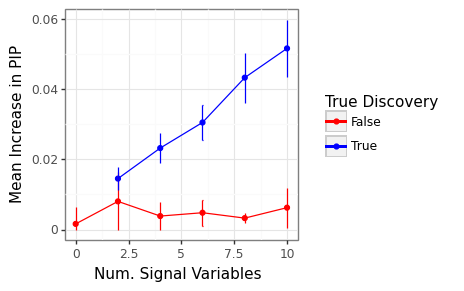

In [1197]:
meas = 'diff'
subset = agg.loc[agg['kappa'] == 0.2].copy()
subset['sigvar'] = ~subset['null']
subset['num_signals'] = (subset['p'] * subset['sparsity']).astype(int)

g = (
    ggplot(
        subset, aes(x='num_signals', y=f'{meas}_mean', color='sigvar')
    )   
    + geom_point() 
    + geom_errorbar(aes(ymin=f'{meas}_ymin', ymax=f'{meas}_ymax'), width=0.001)
    + geom_line()
    + theme_bw()
    + theme(figure_size=(3,3)) # make (3,2) later
    + scale_color_manual(['red', 'blue'])
    + labs(
        x='Num. Signal Variables',
        y='Mean Increase in PIP',
        color='True Discovery',
    )
)
g.save("final-plots/appendixsims/susie_pips_increase.png", dpi=500)
print(g)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 3 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/susie_pips_powerfdr.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


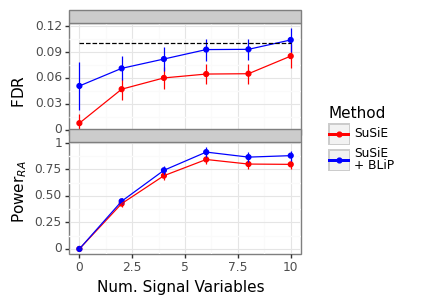

In [1198]:
pdata = []
for d, t in zip(days, ts):
    df = pd.read_csv(f"../blip_sims/data/susie_pips/{d}/{t}/results.csv")
    pdata.append(df)
pdata = pd.concat(pdata, axis='index')
pdata = pdata.drop('k_threshold', axis='columns')

# Update names
pdata['method'] = pdata['method'].apply(lambda x: 'SuSiE\n+ BLiP' if 'BLiP' in x else x)
pdata['method'] = pdata['method'].str.replace("susie", "SuSiE")
#pdata['power'] = 100 * pdata['power'] / (pdata['p'] * pdata['sparsity'])
pdata['num_signals'] = (pdata['p'] * pdata['sparsity']).astype(int)

# melt
pdata = pdata.melt(
    id_vars=[c for c in pdata.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)
gv = set(groupers).union(set(
    ['method', 'num_signals', 'Measurement']
)) - set(['detected', 'sparsity'])
pagg = calc_mean_sem(
    pdata,
    list(gv.intersection(pdata.columns.tolist())),
    meas=['value']
)
xeqy = pagg.loc[pagg['Measurement'] == 'fdr'].copy()
xeqy['value_mean'] = 0.1

for meas in ['value']:
    g = (
        ggplot(
            pagg, aes(x='num_signals', y=f'{meas}_mean', color='method')
        )
        + geom_point() 
        + geom_errorbar(aes(ymin=f'{meas}_ymin', ymax=f'{meas}_ymax'), width=0.001)
        + geom_line()
        + theme_bw()
        + facet_wrap("~Measurement", scales='free', ncol=1)
        + theme(
            strip_text_x=element_blank(),
            figure_size=(3,3)
        )
        + scale_color_manual(['red', 'blue'])
        + labs(
            x='Num. Signal Variables',
            y=r'Power$_{RA}$           FDR      ',
            color='Method',
        )
        + geom_line(
            data=xeqy, linetype='dashed', color='black'
        )
    )
    g.save("final-plots/appendixsims/susie_pips_powerfdr.png", dpi=500)
    print(g)

<a id='jaccard'></a>
## 2.8 Weight function sensitivity / jaccard similarity plots

[1 3 5]


/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: final-plots/appendixsims/weightfn.png


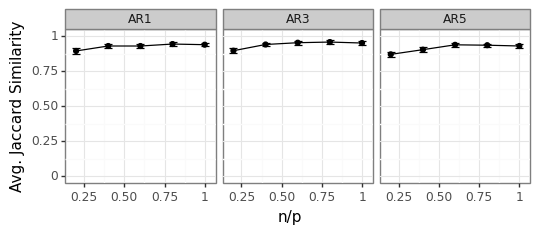

In [1199]:
ds = ['2023-01-18' for _ in range(3)]
ts = ['01-10-35', '01-36-04', '01-52-29']
ks = [1, 3, 5]
all_df = []
for t, d, k in zip(ts, ds, ks):
    df = pd.read_csv(f"data/weight_sensitivity/{d}/{t}/results.csv")
    df['k'] = k
    all_df.append(df)
all_df = pd.concat(all_df, axis='index')
    
agg = calc_mean_sem(
    all_df, 
    group_vals=['k', 'kappa', 'sparsity', 'p'],
    meas=['avg_jaccard'],
)
agg['cov'] = agg['k'].apply(lambda x: f"AR{x}")
print(agg['k'].unique())
meas = 'avg_jaccard'

g = (
    ggplot(agg, aes(x='kappa', y=f'{meas}_mean')) +
    geom_line(color='black') + 
    geom_point(color='black') +
    geom_errorbar(
        aes(ymin=f'{meas}_ymin', ymax=f"{meas}_ymax"), color='black', width=0.05
    ) +
    facet_wrap("~cov") + 
    theme_bw() +
    theme(figure_size=(6,2)) +
    ylim(0,1) + 
    labs(x="n/p", y="Avg. Jaccard Similarity")
)
g.save("final-plots/appendixsims/weightfn.png", dpi=500)
print(g)